In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [2]:
train_x = pd.read_csv("train_X.csv")
train_y = pd.read_csv("train_y.csv")
test_x = pd.read_csv("test_X.csv")

In [3]:
train_y,train_x

(       Brightness_Class     Id
 0                     0  11328
 1                     0   5781
 2                     0  13681
 3                     0  30804
 4                     0  30813
 ...                 ...    ...
 33024                 0   7024
 33025                 0  14012
 33026                 0   4140
 33027                 1  15193
 33028                 1  30255
 
 [33029 rows x 2 columns],
                                     CunstructedAASeq_cln     Id
 0      SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  11328
 1      SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...   5781
 2      SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  13681
 3      SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  30804
 4      SKGEELFTGVVPILVELDGDVNGHTFSVSGEGEGDATYGELTLKFI...  30813
 ...                                                  ...    ...
 33024  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...   7024
 33025  SKGEELFTGVVPTLVELDGDVNGHKFSVSGEGAGDATYSKLTLKFI...  14012
 3

In [4]:
unique_lengths_train = train_x['CunstructedAASeq_cln'].apply(len).unique()
unique_lengths_test = test_x['CunstructedAASeq_cln'].apply(len).unique()
unique_lengths_train, unique_lengths_test

(array([237, 225]), array([237]))

### Since the test set only has sequences with length 237, I will remove the sequences with length 225 from the train set so that the prediction is more accurate:

In [5]:
# Remove sequences of length 225 from train_x
train_x1 = train_x[train_x['CunstructedAASeq_cln'].apply(len) != 225].reset_index(drop=True)

# Find the IDs of the remaining rows
remaining_ids = train_x1['Id']

# Remove corresponding rows in train_y
train_y1 = train_y[train_y['Id'].isin(remaining_ids)].reset_index(drop=True)

In [6]:
df = pd.merge(train_x1, train_y1, on='Id')

In [7]:
unique_brightness_counts = df['Brightness_Class'].value_counts()
print(unique_brightness_counts)
brightness_rate = 18948/12081
print("brightness_rate: {}".format(brightness_rate))


0    18948
1    12081
Name: Brightness_Class, dtype: int64
brightness_rate: 1.5684132108269182


In [8]:
#checking for duplicates
duplicate_counts = df['CunstructedAASeq_cln'].value_counts()

duplicates_with_counts = duplicate_counts[duplicate_counts > 1].reset_index()
duplicates_with_counts.columns = ['Sequence', 'Duplicate_Count']

duplicates_with_counts  # Show the first few entries

,Sequence,Duplicate_Count


### Checking if there is any letters that are common across the entire sequence, and get their indices:

In [9]:
def extract_sequences(df):
    # Extracting all sequences
    all_sequences = df['CunstructedAASeq_cln'].tolist()
    # Extracting sequences for brightness class 0
    zero_df = df[df['Brightness_Class'] == 0]
    zero_sequences = zero_df['CunstructedAASeq_cln'].tolist()
    # Extracting sequences for brightness class 1
    one_df = df[df['Brightness_Class'] == 1]
    one_sequences = one_df['CunstructedAASeq_cln'].tolist()
    return all_sequences, zero_sequences, one_sequences

# Applying the function to df
df_sequences, zero_sequences, one_sequences = extract_sequences(df)

# Function to calculate character counts and find indices with same character
def analyze_sequences(sequence_length, sequences):
    char_counts = []  # List to store the counts for each index
    remove_index = []  # List to store indices where all characters are the same

    for j in range(sequence_length):  # Iterate over each character index
        char_dict = {}  # Dictionary to count characters at the current index
        for seq in sequences:
            if j < len(seq):
                char = seq[j]
                char_dict[char] = char_dict.get(char, 0) + 1

        # Convert dictionary to list of [character, count] pairs and append
        char_counts.append([[k, v] for k, v in char_dict.items()])

        # Check for indices with only one unique character
        if len(char_dict) == 1:
            remove_index.append(j)
    return char_counts, remove_index

def process_sequences(length, all_sequences, zero_sequences, one_sequences):
    # Extract sequences for the given length
    char_counts_all, remove_index_all = analyze_sequences(length, all_sequences)

    print("Indices to Remove:", remove_index_all)
    char_counts_0, remove_index_0 = analyze_sequences(length, zero_sequences)
    print(f"brightness = 0 indices in common for length {length}:", remove_index_0)
    char_counts_1, remove_index_1 = analyze_sequences(length, one_sequences)
    print(f"brightness = 1 indices in common for length {length}:", remove_index_1)
    return char_counts_all, char_counts_0, char_counts_1

# Applying the function to sequence lengths 237 and 225
char_counts, char_counts_0, char_counts_1 = process_sequences(237, df_sequences, zero_sequences, one_sequences)
#char_counts_x stores the occurence of the unique letter at each index


Indices to Remove: [0, 117, 118, 236]
brightness = 0 indices in common for length 237: [0, 117, 118, 236]
brightness = 1 indices in common for length 237: [0, 29, 31, 38, 55, 64, 65, 89, 94, 117, 118, 181, 236]


In [10]:
indices_to_remove = [0, 117, 118, 236]
# Removing characters at specified indices
train_x1['CunstructedAASeq_cln'] = train_x1['CunstructedAASeq_cln'].apply(
    lambda s: ''.join([char for idx, char in enumerate(s) if idx not in indices_to_remove])
)
train_x1

,CunstructedAASeq_cln,Id
0,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIS...,11328
1,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,5781
2,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIR...,13681
3,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,30804
4,KGEELFTGVVPILVELDGDVNGHTFSVSGEGEGDATYGELTLKFIC...,30813
...,...,...
31024,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,7024
31025,KGEELFTGVVPTLVELDGDVNGHKFSVSGEGAGDATYSKLTLKFIC...,14012
31026,KGEELFTGVVPVLVELDGDVNGHKFSVSGEGEGDATYGKLTLKLIC...,4140
31027,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,15193


In [11]:
test_x['CunstructedAASeq_cln'] = test_x['CunstructedAASeq_cln'].apply(
    lambda s: ''.join([char for idx, char in enumerate(s) if idx not in indices_to_remove])
)
test_x

,CunstructedAASeq_cln,Id
0,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,50579
1,KGEELFTGVVPILVELDGDVSGHKFSVSGEGEGDATYGKLTLKFIC...,37987
2,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,53977
3,KGEELFTGVVPILVELDGDVNGHKLSVSGEGEGDATYGKLTLKFIC...,10677
4,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,35653
...,...,...
20681,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,35750
20682,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,53940
20683,KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIC...,14948
20684,KGEELFTRVVPILVGLDGDVNGHKFSVSGEGEGDATYGKLTQKFIC...,17040


### Find out the letters with the most occurence at each index, and list them out.

In [71]:
# Removing elements at specified indices
char_counts1 = [char for idx, char in enumerate(char_counts) if idx not in indices_to_remove]

In [72]:
# Extracting the letter with the maximum count in each inner list
max_counts = [(max(inner_list, key=lambda x: x[1])) for inner_list in char_counts1]

# Creating DataFrame
pattern = pd.DataFrame(max_counts, columns=['Letter', 'Count'])
pattern.head()

,Letter,Count
0,K,30278
1,G,30918
2,E,30430
3,E,30563
4,L,30544


### Observe the sequences behavior based on subsets comparisons:

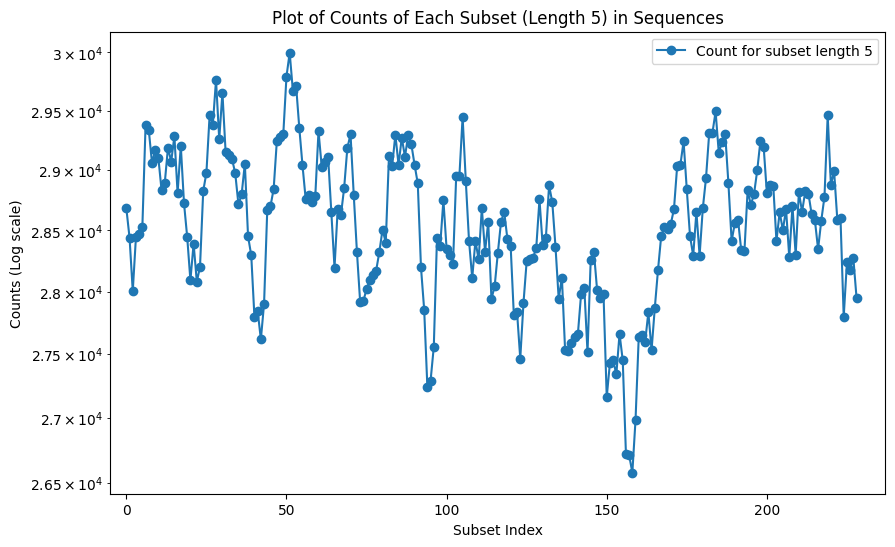

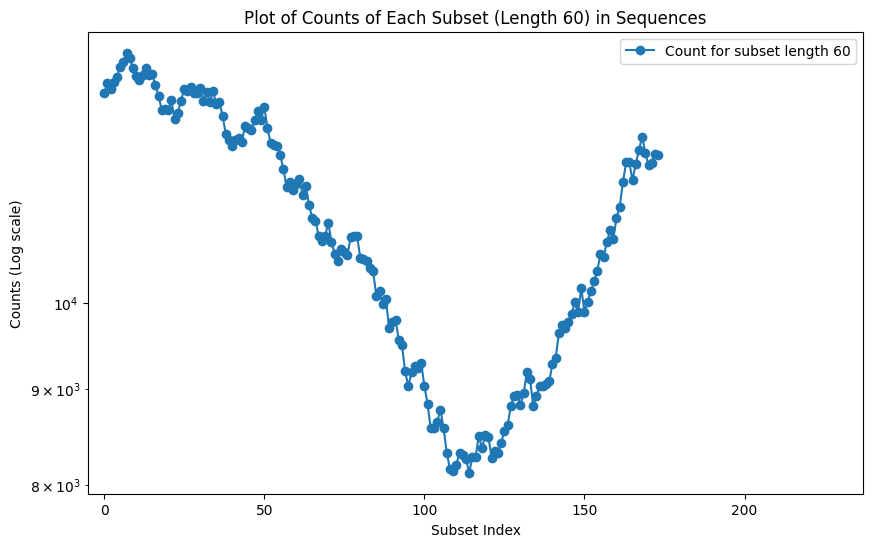

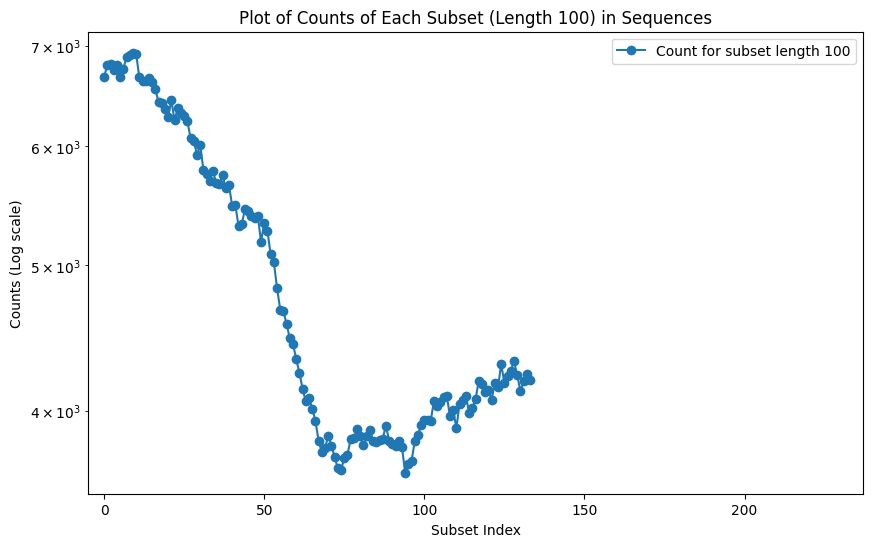

In [74]:
def plot_and_get_subset_counts(df, letters, subset_length):
    # Generate all possible subsets of the given length
    subsets = [''.join(letters[i:i+subset_length]) for i in range(len(letters) - subset_length + 1)]

    # Initialize a dictionary to store the counts
    subset_counts = {}

    # Iterate through each subset
    for subset in subsets:
        # Count how many sequences in df contain the current subset
        count = df['CunstructedAASeq_cln'].apply(lambda seq: subset in seq).sum()
        subset_counts[subset] = count

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(subset_counts)), list(subset_counts.values()), label=f'Count for subset length {subset_length}', marker='o')
    plt.yscale('log')
    plt.xlim(-5, 237)
    plt.xlabel('Subset Index')
    plt.ylabel('Counts (Log scale)')
    plt.title(f'Plot of Counts of Each Subset (Length {subset_length}) in Sequences')
    plt.legend()
    plt.show()

    return subset_counts

# Using a dictionary to store counts for each subset length
all_subset_counts = {}

subset_lengths = [5, 60, 100]
letters = pattern['Letter'].tolist()
for length in subset_lengths:
    all_subset_counts[length] = plot_and_get_subset_counts(train_x1, letters, length)

# Now all_subset_counts contains the counts for each subset length
subset_length_5_counts = all_subset_counts[5]

In [75]:
filtered_counts = {subset: count for subset, count in subset_length_5_counts.items() if count > 29000}

# Finding local maxima among the filtered counts
local_maxima = {}
for i, (subset, count) in enumerate(filtered_counts.items()):
    # Check if the current count is greater than its neighbors
    if i > 0 and i < len(filtered_counts) - 1:
        prev_count = list(filtered_counts.values())[i - 1]
        next_count = list(filtered_counts.values())[i + 1]
        if count > prev_count and count > next_count:
            local_maxima[subset] = count


{'VPILV': 29163,
 'VELDG': 29188,
 'LDGDV': 29284,
 'VSGEG': 29460,
 'GEGEG': 29762,
 'GEGDA': 29654,
 'PVPWP': 29997,
 'PWPTL': 29714,
 'TLSYG': 29326,
 'RYPDH': 29300,
 'AMPEG': 29296,
 'PEGYV': 29271,
 'GYVQE': 29293,
 'TRAEV': 29447,
 'GDGPV': 29493,
 'PVLLP': 29301}

###  The graphs clearly indicate that with increasing subset length, fewer sequences are encompassed. This trend suggests that longer subsets, due to their specific variations, may exclude certain sequences. Consequently, employing shorter subsets appears more rigorous and reduces the risk of overlooking critical letters that could be pivotal in determining the brightness level. This approach ensures a more thorough and inclusive analysis of the sequences.

## Preprocessing of the description data:

In [80]:
T_scale = pd.read_csv("T-scale.csv")
DPPS = pd.read_csv("DPPS.csv")
MS_WHIM = pd.read_csv("MS-WHIM.csv")
Physical = pd.read_csv("Physical.csv")
ST_scale = pd.read_csv("ST-scale.csv")
VHSE_scale = pd.read_csv("VHSE-scale.csv")
Z_scale = pd.read_csv("Z-scale.csv")

def process_df(df):
    df = df.iloc[1:, 1:]  # Removing the first row and column
    new_header = df.iloc[0]  # New header is the first row
    df = df[1:]  # Remove the first row
    df.columns = new_header  # Set the new header
    df.reset_index(drop=True, inplace=True)  # Reset the index
    return df

# Process each DataFrame
T_scale = process_df(T_scale)
DPPS = process_df(DPPS)
MS_WHIM = process_df(MS_WHIM)
Physical = process_df(Physical)
ST_scale = process_df(ST_scale)
VHSE_scale = process_df(VHSE_scale)
Z_scale = process_df(Z_scale)


## First time preparing data (don't have to run after the first time to save time)

### Load Descrition csv

In [87]:
T_scale = pd.read_csv("T-scale.csv")
DPPS = pd.read_csv("DPPS.csv")
MS_WHIM = pd.read_csv("MS-WHIM.csv")
Physical = pd.read_csv("Physical.csv")
ST_scale = pd.read_csv("ST-scale.csv")
VHSE_scale = pd.read_csv("VHSE-scale.csv")
Z_scale = pd.read_csv("Z-scale.csv")

def process_df(df):
    df = df.iloc[1:, 1:]  # Removing the first row and column
    new_header = df.iloc[0]  # New header is the first row
    df = df[1:]  # Remove the first row
    df.columns = new_header  # Set the new header
    df.reset_index(drop=True, inplace=True)  # Reset the index
    return df

# Process each DataFrame
T_scale = process_df(T_scale)
DPPS = process_df(DPPS)
MS_WHIM = process_df(MS_WHIM)
Physical = process_df(Physical)
ST_scale = process_df(ST_scale)
VHSE_scale = process_df(VHSE_scale)
Z_scale = process_df(Z_scale)


### Attach description data to NON-TRUNCATE train_x1 & test_x1

In [88]:
def extend_df_with_aa_mapping(extend_df, mapping_df, sequence_col_name):
    # Prepare a mapping dictionary from mapping_df
    mapping_dict = mapping_df.set_index('AA_1').T.to_dict('list')

    # Expand the sequences in train_df into separate columns
    max_seq_length = extend_df[sequence_col_name].str.len().max()
    seq_expanded = extend_df[sequence_col_name].apply(lambda x: pd.Series(list(x))).fillna('')

    # Apply the mapping to the expanded DataFrame
    mapped_df = seq_expanded.applymap(lambda x: mapping_dict.get(x, [None] * len(mapping_df.columns[1:])))

    # Flatten the DataFrame to match the required structure
    flattened_df = pd.DataFrame()
    for col in mapped_df:
        temp_df = pd.DataFrame(mapped_df[col].to_list(), columns=[f'{d}_{col}' for d in mapping_df.columns[1:]])
        flattened_df = pd.concat([flattened_df, temp_df], axis=1)

    # Concatenate the new columns to the original train_df DataFrame
    extend_df = pd.concat([extend_df.reset_index(drop=True), flattened_df], axis=1)

    return extend_df

In [89]:
train_x1_DPPS = extend_df_with_aa_mapping(train_x1, DPPS, 'CunstructedAASeq_cln')
test_x1_DPPS = extend_df_with_aa_mapping(test_x, DPPS, 'CunstructedAASeq_cln')
print("hi")
train_x1_T_scale = extend_df_with_aa_mapping(train_x1, T_scale, 'CunstructedAASeq_cln')
test_x1_T_scale = extend_df_with_aa_mapping(test_x, T_scale, 'CunstructedAASeq_cln')
print("hi")
train_x1_MS_WHIM = extend_df_with_aa_mapping(train_x1, MS_WHIM, 'CunstructedAASeq_cln')
test_x1_MS_WHIM = extend_df_with_aa_mapping(test_x, MS_WHIM, 'CunstructedAASeq_cln')
print("hi")
train_x1_Physical = extend_df_with_aa_mapping(train_x1, Physical, 'CunstructedAASeq_cln')
test_x1_Physical = extend_df_with_aa_mapping(test_x, Physical, 'CunstructedAASeq_cln')
print("hi")
train_x1_ST_scale = extend_df_with_aa_mapping(train_x1, ST_scale, 'CunstructedAASeq_cln')
test_x1_ST_scale = extend_df_with_aa_mapping(test_x, ST_scale, 'CunstructedAASeq_cln')
print("hi")
train_x1_VHSE_scale = extend_df_with_aa_mapping(train_x1, VHSE_scale, 'CunstructedAASeq_cln')
test_x1_VHSE_scale = extend_df_with_aa_mapping(test_x, VHSE_scale, 'CunstructedAASeq_cln')
print("hi")
train_x1_Z_scale = extend_df_with_aa_mapping(train_x1, Z_scale, 'CunstructedAASeq_cln')
test_x1_Z_scale = extend_df_with_aa_mapping(test_x, Z_scale, 'CunstructedAASeq_cln')

hi
hi
hi
hi
hi
hi


### Remove non numerical columns

In [91]:
def filter_and_drop(df):
    dropped_df = df.drop(df.columns[slice(0, 2)], axis=1)
    return dropped_df

train_DPPS = filter_and_drop(train_x1_DPPS) #log accuracy score = 0.895613780656805
test_DPPS = filter_and_drop(test_x1_DPPS)
LogisticRegression(C=1.0, solver='liblinear', penalty='l1', max_iter=10000) #0.8966773018788875

train_VHSE_scale = filter_and_drop(train_x1_VHSE_scale)#Log Accuracy: 0.8955815527409843
test_VHSE_scale = filter_and_drop(test_x1_VHSE_scale)

train_T_scale = filter_and_drop(train_x1_T_scale)#Log Accuracy: 0.8880079925231236
test_T_scale = filter_and_drop(test_x1_T_scale)

train_MS_WHIM = filter_and_drop(train_x1_MS_WHIM)#Log Accuracy: 0.8672532147346032
test_MS_WHIM = filter_and_drop(test_x1_MS_WHIM)

train_Physical = filter_and_drop(train_x1_Physical)# rvm Accuracy: 0.8513970801508266
test_Physical = filter_and_drop(test_x1_Physical)

train_ST_scale = filter_and_drop(train_x1_ST_scale) #log Accuracy: 0.8951948177511361
test_ST_scale = filter_and_drop(test_x1_ST_scale) 

train_Z_scale = filter_and_drop(train_x1_Z_scale)#log accuracy Scores: 0.8827870701601728
test_Z_scale = filter_and_drop(test_x1_Z_scale)

### Save them to local

In [ ]:
dfs_to_save = {
    'train_DPPS.h5': train_DPPS,
    'test_DPPS.h5': test_DPPS,
    'train_VHSE_scale.h5': train_VHSE_scale,
    'test_VHSE_scale.h5': test_VHSE_scale,
    'train_T_scale.h5': train_T_scale,
    'test_T_scale.h5': test_T_scale,
    'train_MS_WHIM.h5': train_MS_WHIM,
    'test_MS_WHIM.h5': test_MS_WHIM,
    'train_Physical.h5': train_Physical,
    'test_Physical.h5': test_Physical,
    'train_ST_scale.h5': train_ST_scale,
    'test_ST_scale.h5': test_ST_scale,
    'train_Z_scale.h5': train_Z_scale,
    'test_Z_scale.h5': test_Z_scale,
}

# Loop through the dictionary and save each DataFrame as an HDF5 file
for file_name, df in dfs_to_save.items():
    key = file_name.split('.')[0]  # Extract key from file name
    df.to_hdf(file_name, key=key)


## Load data with descriptions

In [12]:
import os

# List all HDF5 files in the current directory
hdf5_files = [f for f in os.listdir('.') if f.endswith('.h5')]

# Loop through the files and read each one as a DataFrame
for file in hdf5_files:
    # Extract the base name without the .h5 extension to use as the DataFrame variable name
    df_name = file.split('.')[0]
    # Dynamically create a variable with the same name as df_name and assign the DataFrame to it
    globals()[df_name] = pd.read_hdf(file, key=df_name)


In [13]:
train_DPPS

,D1_0,D2_0,D3_0,D4_0,D5_0,D6_0,D7_0,D8_0,D9_0,D10_0,...,D1_232,D2_232,D3_232,D4_232,D5_232,D6_232,D7_232,D8_232,D9_232,D10_232
0,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,2.1,1.26,1.15,0.91,5.9,0.74,3.71,3.32,0.25,1.33
1,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,2.1,1.26,1.15,0.91,5.9,0.74,3.71,3.32,0.25,1.33
2,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,2.1,1.26,1.15,0.91,5.9,0.74,3.71,3.32,0.25,1.33
3,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,2.1,1.26,1.15,0.91,5.9,0.74,3.71,3.32,0.25,1.33
4,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,2.1,1.26,1.15,0.91,5.9,0.74,3.71,3.32,0.25,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31024,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,2.1,1.26,1.15,0.91,5.9,0.74,3.71,3.32,0.25,1.33
31025,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,0.21,1.12,3.42,-0.68,-2.27,-1.22,3.11,-2.98,-1.7,1.57
31026,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,2.1,1.26,1.15,0.91,5.9,0.74,3.71,3.32,0.25,1.33
31027,2.47,1.54,-4.28,-0.86,2.77,2.06,-6.18,2.05,2.19,-1.65,...,2.1,1.26,1.15,0.91,5.9,0.74,3.71,3.32,0.25,1.33


In [14]:
train_y1 = train_y1.drop('Id', axis=1)
train_y1

,Brightness_Class
0,0
1,0
2,0
3,0
4,0
...,...
31024,0
31025,0
31026,0
31027,1


## Pipline with F1/accuracy scores for raw data

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, accuracy_score

pipelines = {
    'linear_reg': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'logistic_reg': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=10000))]),
    'random_forest': Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier())]),
    'gradient_boosting': Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingClassifier())]),
    'knn': Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())]),
    'naive_bayes': Pipeline([('scaler', StandardScaler()), ('model', GaussianNB())]),
    'decision_tree': Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeClassifier())]),
    'svm': Pipeline([('scaler', StandardScaler()), ('model', SVC())])
}
# List of dataset pairs with descriptive names
datasets = {
    'DPPS': (train_DPPS, test_DPPS),
    'VHSE_scale': (train_VHSE_scale, test_VHSE_scale),
    'T_scale': (train_T_scale, test_T_scale),
    'MS_WHIM': (train_MS_WHIM, test_MS_WHIM),
    'Physical': (train_Physical, test_Physical),
    'ST_scale': (train_ST_scale, test_ST_scale),
    'Z_scale': (train_Z_scale, test_Z_scale)
}

for dataset_name, (train_set, test_set) in datasets.items():
    print(f"Processing dataset: {dataset_name}")

    for name, pipeline in pipelines.items():
        pipeline.fit(train_set, train_y1.squeeze())

        # Cross-validated predictions
        predicted_values = cross_val_predict(pipeline, train_set, train_y1.squeeze(), cv=5)
        predicted_classes = (predicted_values > 0.5).astype(int)

        # Compute f1 score and accuracy
        f1 = f1_score(train_y1, predicted_classes)
        acc = accuracy_score(train_y1, predicted_classes)

        print(f'{name} - {dataset_name} - Cross-Validation f1 Score: {f1}')
        print(f'{name} - {dataset_name} - Cross-Validation Accuracy: {acc}')
        print()

        # Predict on test set
        pred = pipeline.predict(test_set)
        pred_binary = np.where(pred >= 0.5, 1, 0)

        # Prepare submission DataFrame
        submission_df = pd.DataFrame()
        submission_df['Id'] = test_x['Id']  # Assuming 'Id' column exists in test_set
        submission_df['Brightness_Class'] = pred_binary

        # Save predictions to CSV
        submission_df.to_csv(f'{name}_{dataset_name}.csv', index=False)

output of the above:

Processing dataset: DPPS
    
    linear_reg - DPPS - Cross-Validation f1 Score: 0.8052822565560585
    linear_reg - DPPS - Cross-Validation Accuracy: 0.8322536981533404

    logistic_reg - DPPS - Cross-Validation f1 Score: 0.8689353781410594
    logistic_reg - DPPS - Cross-Validation Accuracy: 0.895613780656805

    random_forest - DPPS - Cross-Validation f1 Score: 0.8194851240943425
    random_forest - DPPS - Cross-Validation Accuracy: 0.8490444422959167

    svm - DPPS - Cross-Validation f1 Score: 0.846286836935167
    svm - DPPS - Cross-Validation Accuracy: 0.8739243933094847

Processing dataset: VHSE_scale

    linear_reg - VHSE_scale - Cross-Validation f1 Score: 0.8175323708885252
    linear_reg - VHSE_scale - Cross-Validation Accuracy: 0.8419543008153663

    logistic_reg - VHSE_scale - Cross-Validation f1 Score: 0.8688683827100535
    logistic_reg - VHSE_scale - Cross-Validation Accuracy: 0.8955815527409843

    random_forest - VHSE_scale - Cross-Validation f1 Score: 0.8206034979819335
    random_forest - VHSE_scale - Cross-Validation Accuracy: 0.8495923168648684

    svm - VHSE_scale - Cross-Validation f1 Score: 0.8425528564116698
    svm - VHSE_scale - Cross-Validation Accuracy: 0.8711205646330852

Processing dataset: T_scale

    linear_reg - T_scale - Cross-Validation f1 Score: 0.8303154750793355
    linear_reg - T_scale - Cross-Validation Accuracy: 0.8535241225949918

    logistic_reg - T_scale - Cross-Validation f1 Score: 0.8606264789636225
    logistic_reg - T_scale - Cross-Validation Accuracy: 0.8880079925231236

    random_forest - T_scale - Cross-Validation f1 Score: 0.817259079155571
    random_forest - T_scale - Cross-Validation Accuracy: 0.8474008185890618

    svm - T_scale - Cross-Validation f1 Score: 0.8358326445467785
    svm - T_scale - Cross-Validation Accuracy: 0.8655773631119276

Processing dataset: MS_WHIM

    linear_reg - MS_WHIM - Cross-Validation f1 Score: 0.8112937273823884
    linear_reg - MS_WHIM - Cross-Validation Accuracy: 0.8386670534016565

    logistic_reg - MS_WHIM - Cross-Validation f1 Score: 0.8374827382126652
    logistic_reg - MS_WHIM - Cross-Validation Accuracy: 0.8672532147346032

    random_forest - MS_WHIM - Cross-Validation f1 Score: 0.8186121694954395
    random_forest - MS_WHIM - Cross-Validation Accuracy: 0.8481098327371169

    svm - MS_WHIM - Cross-Validation f1 Score: 0.8299431065388513
    svm - MS_WHIM - Cross-Validation Accuracy: 0.8593573753585355

Processing dataset: Physical

    linear_reg - Physical - Cross-Validation f1 Score: 0.7979828619094562
    linear_reg - Physical - Cross-Validation Accuracy: 0.8282896645073963

    logistic_reg - Physical - Cross-Validation f1 Score: 0.8170631665299425
    logistic_reg - Physical - Cross-Validation Accuracy: 0.8490766702117374

    random_forest - Physical - Cross-Validation f1 Score: 0.8196420376319412
    random_forest - Physical - Cross-Validation Accuracy: 0.8480131489896549

    svm - Physical - Cross-Validation f1 Score: 0.8205208049511502
    svm - Physical - Cross-Validation Accuracy: 0.8513970801508266

Processing dataset: ST_scale

    linear_reg - ST_scale - Cross-Validation f1 Score: 0.8147900159952386
    linear_reg - ST_scale - Cross-Validation Accuracy: 0.839537207128815

    logistic_reg - ST_scale - Cross-Validation f1 Score: 0.8686909472664136
    logistic_reg - ST_scale - Cross-Validation Accuracy: 0.8951948177511361

    random_forest - ST_scale - Cross-Validation f1 Score: 0.8195987654320988
    random_forest - ST_scale - Cross-Validation Accuracy: 0.8493022656224822

Processing dataset: Z_scale

    linear_reg - Z_scale - Cross-Validation f1 Score: 0.8147900159952386
    linear_reg - Z_scalee - Cross-Validation Accuracy: 0.839537207128815

    logistic_reg - Z_scale - Cross-Validation f1 Score: 0.8686909472664136
    logistic_reg - Z_scale - Cross-Validation Accuracy: 0.8951948177511361

    random_forest - Z_scale - Cross-Validation f1 Score: 0.8195987654320988
    random_forest - Z_scale - Cross-Validation Accuracy: 0.8493022656224822

### The output shows that DPPS description has the overallly best prediction, and logistic regression perform the best out of the other models.

## Some methods to modify the dataset to simplify testing:

### PCA (will train faster but will lower accuracy)

In [ ]:
#find optimal n components
from sklearn.decomposition import PCA

pca = PCA().fit(train_DPPS)  # Fit PCA to the data without specifying n_components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Choose a threshold (e.g., 0.95 for 95% of explained variance)
n_components = np.where(cumulative_variance >= 0.95)[0][0] + 1
n_components

In [19]:
from sklearn.decomposition import PCA

# Create a PCA model and specify the number of components to keep
pca = PCA(n_components=100, svd_solver='randomized')  # Set the number of components you want to keep
pca.fit(train_DPPS)

# Transform the data using the PCA model
X_train_reduced = pca.transform(train_DPPS)
X_test_reduced = pca.transform(test_DPPS)


### Find the optimized Logistic Reg. Parameter

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Updated parameter grid to search
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['liblinear', 'saga'],
     'penalty': ['l1', 'l2']},
    {'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['newton-cg'],
     'penalty': ['l2']}
]

# Grid search with cross-validation
log_reg = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_reduced, train_y1.squeeze())  # X_train_reduced and train_y1 are your data

# Best parameters
print("Best parameters:", grid_search.best_params_)

### This can help find the best parameter for the Logistic regression model, but it takes way too long for a dataset that has a lot of features.

## Pipline with modified parameter to optimize model:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, accuracy_score

pipelines = {
    'X_train_reduced_log_reg': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(C=0.1, solver='sag', penalty='l2',warm_start =True, max_iter=10000))])
}

datasets = {
    'DPPS': (train_DPPS, test_DPPS),
    'VHSE_scale': (train_VHSE_scale, test_VHSE_scale),
    'T_scale': (train_T_scale, test_T_scale),
    'MS_WHIM': (train_MS_WHIM, test_MS_WHIM),
    'Physical': (train_Physical, test_Physical),
    'ST_scale': (train_ST_scale, test_ST_scale),
    'Z_scale': (train_Z_scale, test_Z_scale)
}

for name, pipeline in pipelines.items():
    pipeline.fit(train_DPPS, train_y1.squeeze())

    # Predictions from Cross-validation
    predicted_values = cross_val_predict(pipeline, train_DPPS, train_y1.squeeze(), cv=5)
    predicted_classes = (predicted_values > 0.5).astype(int)

    # compute f1 score and accuracy
    f1 = f1_score(train_y1, predicted_classes)
    acc = accuracy_score(train_y1, predicted_classes)

    print(f'{name} Cross-Validation f1 Scores: {f1}')
    #print(f'{name} Average f1 Score: {f1.mean():.5f}')
    print(f'{name} Cross-Validation accuracy Scores: {acc}')
    #print(f'{name} Average accuracy Score: {acc.mean():.5f}')
    print()

    pred = pipeline.predict(test_DPPS)
    pred_binary = np.where(pred >= 0.5, 1, 0)

    submission_df = pd.DataFrame()
    submission_df['Id'] = test_x['Id']
    submission_df['Brightness_Class'] = pred_binary

    submission_df.to_csv(f'{name}.csv', index=False)

### Parameter Tuning output

C=1, solver='lbfgs', penalty='l2'

    X_train_reduced_log_reg Cross-Validation f1 Scores: 0.8689353781410594

    X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.895613780656805

C=0.1, solver='lbfgs', penalty='l2'

    X_train_reduced_log_reg Cross-Validation f1 Scores: 0.87033073537132

    X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.896516162299784 !!! THIS IS THE BEST MODEL That i can get

C=0.01, solver='lbfgs', penalty='l2'

    X_train_reduced_log_reg Cross-Validation f1 Scores: 0.8627111984282908

    X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.8873956621225305

In [ ]:
n=100

X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7377360685616784
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7820426053047149

C=100, solver='liblinear', penalty='l1'
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7383253755677186
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7827516194527699

C=1, solver='liblinear', penalty='l1'
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7376222256712712
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7820748332205356
    
C=0.01, solver='liblinear', penalty='l1' 比之前的快
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7125044251268536
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7644461632666215
    
C=0.01, solver='liblinear', penalty='l2' 比saga的高
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7306304230975966
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.773888942602082
    
C=10, solver='liblinear', penalty='l1'
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7406604467500291
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7841051919172387

C=10, solver='saga', penalty='l1'
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7445947508382471
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7864256018563279
    
C=10, solver='newton-cg', penalty='l2'
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7449333436079216
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7866511972670728 !!!!!!!
C=100, solver='newton-cg', penalty='l2'
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7446144360090947
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7864256018563279
    
C=1, solver='lbfgs', penalty='l2'
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7455777046642151
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7881659093106449

C=0.1, solver='lbfgs', penalty='l2'
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7426098380926619
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7853298527184247
    
C=100, solver='saga', penalty='l1' 高了很多
X_train_reduced_log_reg Cross-Validation f1 Scores: 0.7383456895547879
X_train_reduced_log_reg Cross-Validation accuracy Scores: 0.7827516194527699
    


## Feature selection

### Recursive Feature Elimination (RFE) 

In [ ]:
#CV to find the best n_features_to_select
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

# Example model
model = LogisticRegression()

# Create RFECV (Recursive Feature Elimination with Cross-Validation)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(train_DPPS, train_y1)

print("Optimal number of features: %d" % rfecv.n_features_)

# Plot number of features vs. cross-validation scores
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression  # or any other suitable model
model = LogisticRegression()
# Assuming train_x and train_y are your training data and labels
# Let's say you want to select 10 features
selector = RFE(model, n_features_to_select=200)
selector = selector.fit(train_DPPS, train_y1.squeeze())
# Assuming test_x is your test data
X_train_selected = selector.transform(train_DPPS)
X_test_selected = selector.transform(test_DPPS)